In [1]:
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import Image as displayimg
from IPython.display import display
import os

import pathlib
BATCH_SIZE = 32
IMG_HEIGHT = 28
IMG_WIDTH = 28

mnist = tf.keras.datasets.mnist
Sequential = tf.keras.models.Sequential
layers = tf.keras.layers



BATCH_SIZE = 32
IMG_HEIGHT = 28
IMG_WIDTH = 28
DATASET_1_SRC= "digits"
DATASET_1_INVERTED = "inv_digits/"
DATASET_1_TARGET = "dataset"

DATASET_THIN_SRC = "thin_digits"
DATASET_THIN_TARGET = "dataset_thin"


print("TensorFlow version:", tf.__version__)


2023-05-31 12:21:03.975688: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 12:21:04.009859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 12:21:04.010725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 12:21:04.600434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


model = Sequential([
  layers.Flatten(input_shape=(28, 28)),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
])
predictions = model(x_train[:1]).numpy()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [3]:
model.fit(
    x_train, y_train, 
    verbose=1,
    epochs=5
    )

Epoch 1/5
1875/1875 [==============================] - 2s 874us/step - loss: 0.2316 - accuracy: 0.9313
Epoch 2/5
1875/1875 [==============================] - 2s 853us/step - loss: 0.0965 - accuracy: 0.9706
Epoch 3/5
1875/1875 [==============================] - 2s 844us/step - loss: 0.0694 - accuracy: 0.9778
Epoch 4/5
1875/1875 [==============================] - 2s 837us/step - loss: 0.0514 - accuracy: 0.9842
Epoch 5/5
1875/1875 [==============================] - 2s 825us/step - loss: 0.0410 - accuracy: 0.9871


In [4]:
loss, accuracy = model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0767 - accuracy: 0.9764 - 240ms/epoch - 766us/step


In [5]:
print(f"Wyuczona sieć na zbiorze testowym posiada skuteczność {round(accuracy*100,2)} %")

Wyuczona sieć na zbiorze testowym posiada skuteczność 97.64 %


In [6]:
# Przygotowywanie moich danych:

def make_classification_dataset(path: str):
    os.makedirs(path, exist_ok=True)
    for num in range(10):
        os.makedirs(os.path.join(path, str(num)), exist_ok=True)
        
def add_padding(grayscale_image, amount=4, background_color=255):
    width = grayscale_image.width
    result = Image.new(img.mode, (width+2*amount, width+2*amount), (background_color))
    result.paste(grayscale_image, (amount, amount))
    return result
    
make_classification_dataset(DATASET_THIN_TARGET)

for class_type in os.listdir(DATASET_THIN_SRC):
    for image in os.listdir(os.path.join(DATASET_THIN_SRC, class_type)):
        path = os.path.join(DATASET_THIN_SRC, class_type, image)
        
        img = Image.open(path).convert("L") # open and convert to grayscale
        img = ImageOps.scale(img, (20/img.width)) # scale to 20 px
        img = add_padding(img) # add padding to 28x28
        img = ImageOps.invert(img) # invert, because source images are white background and black in
        
        target_path = os.path.join(DATASET_THIN_TARGET, class_type, image)
        img.save(target_path)


In [7]:


def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

def dataset_evaluate(target_path: str):
  data_dir = pathlib.Path(target_path).with_suffix('')
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale')

  ds = train_ds.map(process)
  model.evaluate(ds)
  
dataset_evaluate(DATASET_THIN_TARGET)

Found 101 files belonging to 10 classes.
4/4 [==============================] - 0s 1ms/step - loss: 2.4482 - accuracy: 0.5149


2023-05-31 12:21:14.469845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [101]
	 [[{{node Placeholder/_0}}]]
2023-05-31 12:21:14.470087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [101]
	 [[{{node Placeholder/_4}}]]


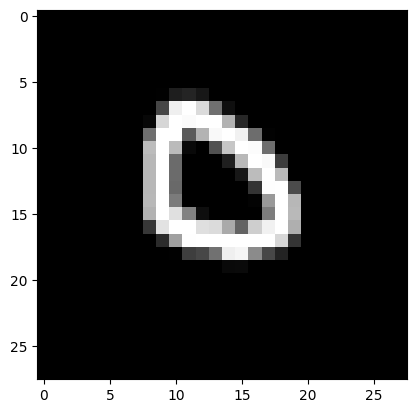

0:0.08%
1:0.0%
2:0.06%
3:0.0%
4:67.24%
5:0.0%
6:0.0%
7:3.95%
8:0.0%
9:28.67%


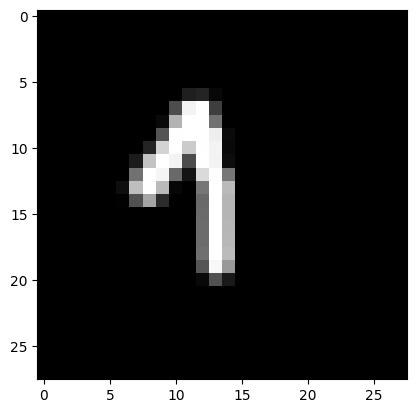

0:0.0%
1:4.71%
2:0.15%
3:0.27%
4:28.71%
5:0.15%
6:0.0%
7:4.04%
8:48.74%
9:13.22%


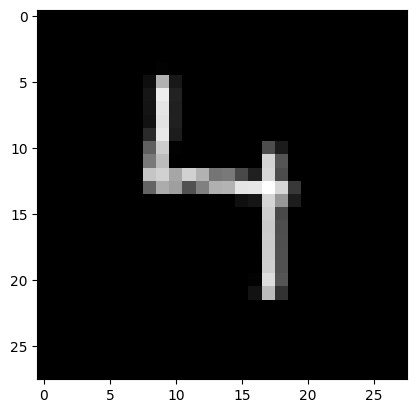

0:0.0%
1:0.04%
2:0.0%
3:0.0%
4:98.95%
5:0.04%
6:0.01%
7:0.8%
8:0.02%
9:0.15%


In [8]:
import numpy as np
from matplotlib import pyplot as plt
import random

def predict(path: str):
    np_image = Image.open(path).convert("L") # changing to grayscale
    np_image = np.array(np_image).astype('float32')/255.0 # dividing by 255 as in other places
    np_image = np.expand_dims(np_image, axis=0) # we do it to make it a list of images
    prediction = model.predict(np_image, verbose=0) # 
    
    plt.imshow(np_image[0], cmap='gray')
    plt.show()
    print("\n".join([ f"{i}:{(round(float(n)*100, 2))}%" for i, n in zip(range(10), prediction[0])]))

def predict_dataset(target_path: str):
    imgs = []
    for class_type in os.listdir(target_path):
        for image in os.listdir(os.path.join(target_path, class_type)):
            imgs.append(os.path.join(target_path, class_type, image))
            
    random.shuffle(imgs)
    for path in imgs[:3]:
        predict(path)

predict_dataset(DATASET_THIN_TARGET)
        
